> This case study will focus on the prediction of optimal formulations of concrete mixture-based data from designed experiments.

In [11]:
library(AppliedPredictiveModeling)
data(concrete)
str(concrete)

'data.frame':	1030 obs. of  9 variables:
 $ Cement             : num  540 540 332 332 199 ...
 $ BlastFurnaceSlag   : num  0 0 142 142 132 ...
 $ FlyAsh             : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Water              : num  162 162 228 228 192 228 228 228 228 228 ...
 $ Superplasticizer   : num  2.5 2.5 0 0 0 0 0 0 0 0 ...
 $ CoarseAggregate    : num  1040 1055 932 932 978 ...
 $ FineAggregate      : num  676 676 594 594 826 ...
 $ Age                : int  28 28 270 365 360 90 365 28 28 28 ...
 $ CompressiveStrength: num  80 61.9 40.3 41 44.3 ...


In [75]:
str(mixtures)

'data.frame':	1030 obs. of  9 variables:
 $ Cement             : num  0.2231 0.2217 0.1492 0.1492 0.0853 ...
 $ BlastFurnaceSlag   : num  0 0 0.0639 0.0639 0.0569 ...
 $ FlyAsh             : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Water              : num  0.0669 0.0665 0.1023 0.1023 0.0825 ...
 $ Superplasticizer   : num  0.00103 0.00103 0 0 0 ...
 $ CoarseAggregate    : num  0.43 0.433 0.418 0.418 0.42 ...
 $ FineAggregate      : num  0.279 0.278 0.266 0.266 0.355 ...
 $ Age                : int  28 28 270 365 360 90 365 28 28 28 ...
 $ CompressiveStrength: num  80 61.9 40.3 41 44.3 ...


In [76]:
library(Hmisc)
describe(concrete)

concrete 

 9  Variables      1030  Observations
--------------------------------------------------------------------------------
Cement 
       n  missing distinct     Info     Mean      Gmd      .05      .10 
    1030        0      278        1    281.2    118.5    143.7    153.5 
     .25      .50      .75      .90      .95 
   192.4    272.9    350.0    425.0    480.0 

lowest : 102.0 108.3 116.0 122.6 132.0, highest: 522.0 525.0 528.0 531.3 540.0
--------------------------------------------------------------------------------
BlastFurnaceSlag 
       n  missing distinct     Info     Mean      Gmd      .05      .10 
    1030        0      185    0.904     73.9    91.71      0.0      0.0 
     .25      .50      .75      .90      .95 
     0.0     22.0    142.9    192.0    236.0 

lowest :   0.0  11.0  13.6  15.0  17.2, highest: 290.2 305.3 316.1 342.1 359.4
--------------------------------------------------------------------------------
FlyAsh 
       n  missing distinct     Info   

In [77]:
#missng 
any(is.na(concrete))

[1] FALSE

Loading required package: lattice
Loading required package: ggplot2


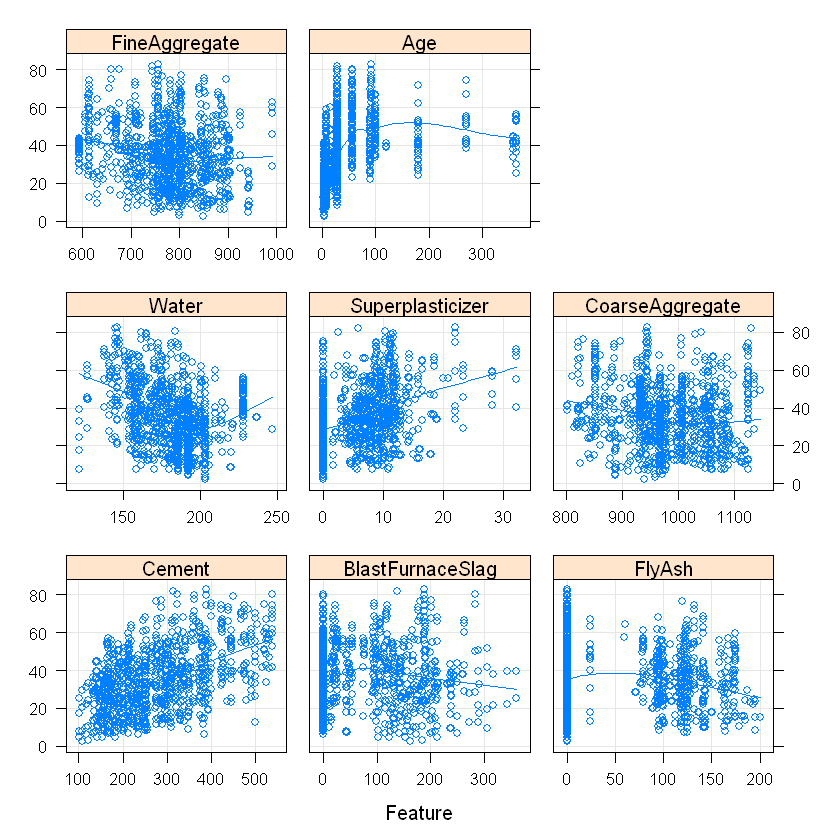

In [14]:
library(caret)
featurePlot(x=concrete[,-9],y=concrete$CompressiveStrength,
            between=list(x=1,y=1),type=c("g","p","smooth"))

remove duplicte observation, replace their CompressiveStrength with the average.

In [12]:
library(plyr)
averaged <- ddply(mixtures,.(Cement,BlastFurnaceSlag,FlyAsh,Water,
                            Superplasticizer,CoarseAggregate,FineAggregate,Age),
                 function(x) c(CompressiveStrength=mean(x$CompressiveStrength)))
                  
head(averaged)

Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
0.22309440,0.00000000,0,0.06692832,0.001032844,0.4296633,0.2792811,28,79.99
0.22172039,0.00000000,0,0.06651612,0.001026483,0.4331759,0.2775611,28,61.89
0.14917003,0.06393001,0,0.10228802,0.000000000,0.4181247,0.2664872,270,40.27
0.14917003,0.06393001,0,0.10228802,0.000000000,0.4181247,0.2664872,365,41.05
0.08534961,0.05689974,0,0.08251322,0.000000000,0.4204736,0.3547638,360,44.30
0.12036199,0.05158371,0,0.10316742,0.000000000,0.4217195,0.3031674,90,47.03


In [15]:
set.seed(830)
trn_id <- createDataPartition(averaged$CompressiveStrength,p=3/4)[[1]]
trn <- averaged[trn_id,]
vld <- averaged[-trn_id,]

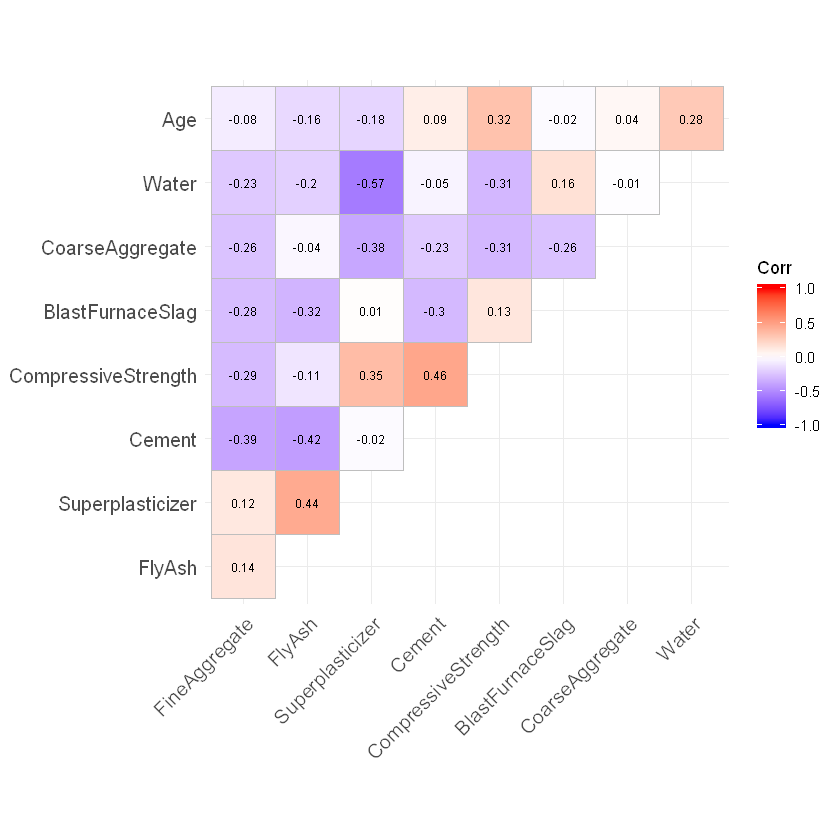

In [81]:
#COR
library(ggcorrplot)
ggcorrplot(round(cor(trn),2), hc.order = TRUE, type = "upper", lab = TRUE,lab_size = 2.5)

In [82]:
mdl_formula <- paste("CompressiveStrength ~ (.)^2 + I(Cement^2) + ",
 "I(BlastFurnaceSlag^2) + I(FlyAsh^2) + I(Water^2) +",
 " I(Superplasticizer^2) + I(CoarseAggregate^2) + ",
 "I(FineAggregate^2) + I(Age^2)")
mdl_formula <- as.formula(mdl_formula)

In [17]:
ctrl <- trainControl(method = "repeatedcv",repeats = 5,number=10)

In [84]:
options(warn = -1)
set.seed(830)
fit_reg <- train(mdl_formula,data=trn,method = "lm",trControl=ctrl)
fit_reg

Linear Regression 

745 samples
  8 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 670, 670, 670, 671, 669, 671, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  7.723094  0.7855035  5.894151

Tuning parameter 'intercept' was held constant at a value of TRUE

In [85]:
# Warning message in predict.lm(modelFit, newdata):
# "prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata)
#  Notice there is NA Coefficients for  some predictors
fit_reg$finalModel


Call:
lm(formula = .outcome ~ ., data = dat)

Coefficients:
                        (Intercept)                               Cement  
                          7.105e+02                           -1.177e+03  
                   BlastFurnaceSlag                               FlyAsh  
                         -7.357e+02                           -7.485e+02  
                              Water                     Superplasticizer  
                         -4.715e+02                           -3.173e+05  
                    CoarseAggregate                        FineAggregate  
                         -7.927e+02                                   NA  
                                Age                        `I(Cement^2)`  
                          4.838e-01                            5.117e+02  
            `I(BlastFurnaceSlag^2)`                        `I(FlyAsh^2)`  
                         -2.035e+02                           -5.190e+02  
                       `I(Water^2)`    

In [86]:
options(warn = 0)
set.seed(830)
fit_pls <- train(mdl_formula,data=trn,method = "pls",preProc=c("center","scale"),
                 tuneLength=15,trControl=ctrl)
fit_pls

Partial Least Squares 

745 samples
  8 predictor

Pre-processing: centered (44), scaled (44) 
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 670, 670, 670, 671, 669, 671, ... 
Resampling results across tuning parameters:

  ncomp  RMSE       Rsquared   MAE     
   1     10.646003  0.5928792  8.552908
   2      9.785106  0.6577391  7.572928
   3      9.096630  0.7013210  7.102892
   4      8.798495  0.7207861  6.816094
   5      8.665767  0.7290973  6.687399
   6      8.547451  0.7370908  6.650636
   7      8.349020  0.7500032  6.466054
   8      8.223360  0.7575886  6.344237
   9      8.015248  0.7698827  6.110232
  10      7.846567  0.7789616  6.030790
  11      7.775659  0.7827712  5.940950
  12      7.757324  0.7835445  5.899578
  13      7.739539  0.7842031  5.880909
  14      7.720793  0.7851388  5.928504
  15      7.705953  0.7864174  5.916551

RMSE was used to select the optimal model using the smallest value.
The final value used for the mode

In [88]:
grid_enet <- expand.grid(
    lambda=c(0,0.001,0.01,0.1),
    fraction=seq(0.05,1,length=20))
set.seed(830)
fit_enet <- train(mdl_formula,data=trn,method = "enet",
                 preProc=c("center","scale"),tuneGrid=grid_enet,trControl=ctrl)
fit_enet

Elasticnet 

745 samples
  8 predictor

Pre-processing: centered (44), scaled (44) 
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 670, 670, 670, 671, 669, 671, ... 
Resampling results across tuning parameters:

  lambda  fraction  RMSE       Rsquared   MAE      
  0.000   0.05       9.043607  0.7305465   7.023450
  0.000   0.10       8.392551  0.7575808   6.495321
  0.000   0.15       8.086971  0.7675736   6.230195
  0.000   0.20       7.936305  0.7758592   6.102014
  0.000   0.25       7.833346  0.7808990   6.013212
  0.000   0.30       7.771949  0.7835726   5.952888
  0.000   0.35       7.737510  0.7850356   5.914953
  0.000   0.40       7.728285  0.7853525   5.906741
  0.000   0.45       7.736562  0.7848193   5.909432
  0.000   0.50       7.734757  0.7849131   5.907230
  0.000   0.55       7.730327  0.7851484   5.903404
  0.000   0.60       7.726634  0.7853395   5.899851
  0.000   0.65       7.722952  0.7855363   5.896024
  0.000   0.70       7.71

In [89]:
names(trn)

[1] "Cement"              "BlastFurnaceSlag"    "FlyAsh"             
[4] "Water"               "Superplasticizer"    "CoarseAggregate"    
[7] "FineAggregate"       "Age"                 "CompressiveStrength"

In [91]:
grid_mars <- expand.grid(
                        degree=1,
                        nprune=2:25)
set.seed(830)
fit_mars <- train(CompressiveStrength~.,data=trn,method = "earth",
                 tuneGrid=grid_mars,trControl=ctrl)
fit_mars

Loading required package: earth
Loading required package: plotmo
Loading required package: plotrix
Loading required package: TeachingDemos

Attaching package: 'TeachingDemos'

The following objects are masked from 'package:Hmisc':

    cnvrt.coords, subplot



Multivariate Adaptive Regression Spline 

745 samples
  8 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 670, 670, 670, 671, 669, 671, ... 
Resampling results across tuning parameters:

  nprune  RMSE       Rsquared   MAE      
   2      13.500824  0.3435302  10.696381
   3      11.223251  0.5456629   8.888472
   4       9.796802  0.6539865   7.848132
   5       7.992045  0.7700922   6.252316
   6       7.649110  0.7903590   5.877639
   7       7.456397  0.8009835   5.732450
   8       7.136318  0.8175005   5.536865
   9       6.940526  0.8276724   5.385208
  10       6.810061  0.8340687   5.282641
  11       6.674129  0.8407660   5.179942
  12       6.619980  0.8432594   5.153062
  13       6.555531  0.8459330   5.117922
  14       6.513455  0.8478637   5.113572
  15       6.519875  0.8474393   5.107206
  16       6.515150  0.8477609   5.103737
  17       6.516516  0.8477047   5.103780
  18       6.516516  0.8477047   5.1

In [92]:
set.seed(830)
fit_svm <- train(CompressiveStrength~.,data=trn,method = "svmRadial",
                tuneLength=15,preProcess=c("center","scale"),trControl=ctrl)
fit_svm

Support Vector Machines with Radial Basis Function Kernel 

745 samples
  8 predictor

Pre-processing: centered (8), scaled (8) 
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 670, 670, 670, 671, 669, 671, ... 
Resampling results across tuning parameters:

  C        RMSE      Rsquared   MAE     
     0.25  7.758305  0.7956263  5.822621
     0.50  7.058754  0.8253142  5.175484
     1.00  6.547014  0.8471955  4.744021
     2.00  6.252487  0.8599369  4.482242
     4.00  6.064011  0.8679589  4.279206
     8.00  6.015191  0.8697259  4.191704
    16.00  5.957705  0.8722348  4.104620
    32.00  6.027202  0.8689867  4.096498
    64.00  6.150089  0.8647463  4.116593
   128.00  6.499282  0.8503728  4.181553
   256.00  6.964640  0.8304998  4.311861
   512.00  7.489037  0.8061010  4.477959
  1024.00  8.019207  0.7813757  4.609247
  2048.00  9.040122  0.7407688  4.877798
  4096.00  9.831002  0.7102284  5.181206

Tuning parameter 'sigma' was held constant at a val

In [10]:
# library(doParallel)
# registerDoParallel(makeCluster(4))

In [ ]:
library(parallel)
setDefaultCluster(makeCluster(4))

grid_nnet <- expand.grid(
                        decay=c(0.001,0.01,0.1),
                        size=seq(1,27,by=2),
                        bag=F)
set.seed(830)
fit_nnet <- train(CompressiveStrength~.,data=trn,method = "avNNet",
                 tuneGrid=grid_nnet,preProc=c("center","scale"),linout=T,trace=F,
                 maxit=1000,trControl=ctrl)
fit_nnet

In [ ]:
set.seed(830)
fit_cart <- train(CompressiveStrength~.,data=trn,method = "rpart",
                  tuneLength=30,trControl=ctrl)
fit_cart

In [ ]:
set.seed(830)
fit_ctree <- train(CompressiveStrength~.,data=trn,method = "ctree",
                  tuneLength=10,trControl=ctrl)
fit_ctree

In [ ]:
set.seed(830)
fit_mdtree <- train(CompressiveStrength~.,data=trn,method = "M5",
                   trControl=ctrl)
fit_mdtree

In [ ]:
set.seed(830)
fit_cartBag <- train(CompressiveStrength~.,data=trn,method = "treebag",
                   trControl=ctrl)

In [ ]:
set.seed(830)
fit_rf <- train(CompressiveStrength~.,data=trn,method = "rf",
               tuneLength=10,ntree=1000,importance=T,trControl=ctrl)

In [ ]:
set.seed(830)
grid_gbm <- expand.grid(
                        n.trees,
                        interaction.depth, 
                        shrinkage, 
                        n.minobsinnode)
fit_gbm <- train(CompressiveStrength~.,data=trn,method = "gbm",
                tuneGrid=grid_gbm,verbose=F,trControl=ctrl)

In [ ]:
set.seed(830)
grid_cubist <- expand.grid(
                          )
fit_cubist <- train(CompressiveStrength~.,data=trn,method = "cubist",
                   tuneGrid=grid_cubist,trControl=ctrl)

- &#x1F4C8;Linear Regression and Its Cousins
    - Linear Reg.
    - PLS
    - Ridge
    - Elastic Net
- &#x1F30C;Nonlinear Regression Models
    - Neural Net
    - MARS
    - SVM
    - KNN
- &#x1F384;Regression Trees and Rule-Based Models
    - Tree
    - Cond. Tree
    - Bagged Cond. Tree
    - M5
    - Random Forest
    - Cond. Random Forest
    - Boosted Tree
    - Cubist

In [ ]:
fit_resamples <- resamples(list(
                                ""=,))